<a href="https://colab.research.google.com/github/Sanjeevani200303/ALGO_TRADE_SYS/blob/main/SYS_algo_trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Algorithmic trading, also called automated trading uses a computer program that follows a defined set of instructions (an algorithm) to place a trade. We can build many trading algorithms by applying different strategies using technical indicators and valuation metrics.

The process of running an investing strategy is divided into three steps.

1.	Collect data
2.	Develop hypothesis for a strategy
3.	Backtest the strategy
4.	Implement the strategy in production

Here, we are trying to build momentum and value investing strategies, the two of many investing strategies of the market,based on some valuation metrics, on S&P 500 stocks.


In [11]:
# STEP 1: Import libraries
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# STEP 2: Load S&P 500 companies list
url = "https://raw.githubusercontent.com/datasets/s-and-p-500-companies/master/data/constituents.csv"
df = pd.read_csv(url)

# Display first few rows to confirm
print("✅ Loaded S&P 500 data:")
print(df.head())

# STEP 3: Pick a few tickers to start (you can expand later)
tickers = df['Symbol'].head(10).tolist()
print("\nSelected tickers:", tickers)

# STEP 4: Download 1 year of adjusted closing prices
data = yf.download(tickers, start="2024-01-01", end="2025-01-01", auto_adjust=False)['Adj Close']

print("\n✅ Downloaded historical price data:")
print(data.head())


[**********************90%******************     ]  9 of 10 completed

✅ Loaded S&P 500 data:
  Symbol             Security             GICS Sector  \
0    MMM                   3M             Industrials   
1    AOS          A. O. Smith             Industrials   
2    ABT  Abbott Laboratories             Health Care   
3   ABBV               AbbVie             Health Care   
4    ACN            Accenture  Information Technology   

                GICS Sub-Industry    Headquarters Location  Date added  \
0        Industrial Conglomerates    Saint Paul, Minnesota  1957-03-04   
1               Building Products     Milwaukee, Wisconsin  2017-07-26   
2           Health Care Equipment  North Chicago, Illinois  1957-03-04   
3                   Biotechnology  North Chicago, Illinois  2012-12-31   
4  IT Consulting & Other Services          Dublin, Ireland  2011-07-06   

       CIK      Founded  
0    66740         1902  
1    91142         1916  
2     1800         1888  
3  1551152  2013 (1888)  
4  1467373         1989  

Selected tickers: ['MMM', 'AOS',

[*********************100%***********************]  10 of 10 completed


✅ Downloaded historical price data:
Ticker               A        ABBV         ABT         ACN        ADBE  \
Date                                                                     
2024-01-02  136.937820  148.974823  105.697906  336.625275  580.070007   
2024-01-03  129.446960  149.571365  105.380379  327.892395  571.789978   
2024-01-04  129.289032  150.503479  106.785210  327.087006  567.049988   
2024-01-05  128.854782  151.137360  106.612007  326.630951  564.599976   
2024-01-08  131.637955  150.475555  108.151527  330.250275  580.549988   

Ticker            AES        AFL         AMD        AOS        MMM  
Date                                                                
2024-01-02  17.501251  80.186378  138.580002  78.529305  87.619736  
2024-01-03  17.130232  80.099731  135.320007  75.896873  85.859390  
2024-01-04  17.075935  79.242783  136.009995  76.542923  86.162064  
2024-01-05  17.012589  79.647186  138.580002  76.215080  86.496620  
2024-01-08  17.256920  79.7916

 Top momentum stocks (6-month performance):
Ticker
MMM     0.283961
ACN     0.167663
AFL     0.167456
ABT     0.107035
ABBV    0.089205
A       0.071733
AOS    -0.149778
ADBE   -0.216713
AES    -0.250760
AMD    -0.264865
Name: 2024-12-31 00:00:00, dtype: float64


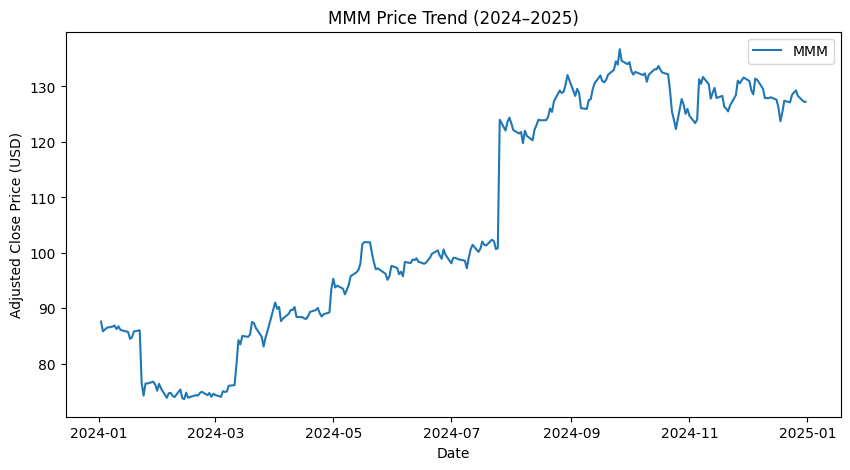

In [12]:
# STEP 5: Calculate Daily Returns
daily_returns = data.pct_change().dropna()

# STEP 6: Calculate Cumulative Returns
cumulative_returns = (1 + daily_returns).cumprod() - 1

# STEP 7: Calculate Momentum (e.g., 6-month return)
momentum_6m = data.pct_change(126)  # 126 trading days ≈ 6 months
momentum_latest = momentum_6m.iloc[-1].sort_values(ascending=False)

print(" Top momentum stocks (6-month performance):")
print(momentum_latest.head(10))


top_stock = momentum_latest.index[0]
plt.figure(figsize=(10,5))
plt.plot(data[top_stock], label=top_stock)
plt.title(f"{top_stock} Price Trend (2024–2025)")
plt.xlabel("Date")
plt.ylabel("Adjusted Close Price (USD)")
plt.legend()
plt.show()


In [14]:
# STEP 8: Collect Valuation Metrics
value_metrics = []

for ticker in tickers:
    try:
        info = yf.Ticker(ticker).info
        value_metrics.append({
            'Ticker': ticker,
            'PE_Ratio': info.get('trailingPE'),
            'PB_Ratio': info.get('priceToBook'),
            'Dividend_Yield': info.get('dividendYield'),
            'Market_Cap': info.get('marketCap')
        })
    except Exception as e:
        print(f" Skipping {ticker}: {e}")

# Create DataFrame
value_df = pd.DataFrame(value_metrics)
print("\n✅ Sample of Value Metrics:")
print(value_df.head())




✅ Sample of Value Metrics:
  Ticker    PE_Ratio    PB_Ratio  Dividend_Yield    Market_Cap
0    MMM   26.958532   19.401974            1.74   89792970752
1    AOS   17.699461    4.956972            2.09    9143052288
2    ABT   15.876884    4.312869            1.87  219758624768
3   ABBV  169.824430 -148.809370            3.16  393190047744
4    ACN   19.836214    4.804346            2.67  149459664896


In [16]:
# STEP 9: Merge Momentum and Value Data
combined = pd.DataFrame(momentum_latest).reset_index()
combined.columns = ['Ticker', 'Momentum_Score']

# Merge with Value Metrics
combined = combined.merge(value_df, on='Ticker', how='left')

# Rank by Momentum and Value (lower PE = better)
combined['Value_Score'] = (1 / combined['PE_Ratio'])
combined['Composite_Score'] = combined['Momentum_Score'].rank(ascending=False) + combined['Value_Score'].rank(ascending=False)

# Sort by combined score
final_ranking = combined.sort_values('Composite_Score', ascending=False)

print("\n Top Combined (Momentum + Value) Stocks:")
print(final_ranking.head(10))



 Top Combined (Momentum + Value) Stocks:
  Ticker  Momentum_Score    PE_Ratio    PB_Ratio  Dividend_Yield  \
9    AMD       -0.264865  125.878944    6.405195             NaN   
4   ABBV        0.089205  169.824430 -148.809370            3.16   
7   ADBE       -0.216713   20.620562   11.809876             NaN   
5      A        0.071733   34.768150    6.609385            0.68   
6    AOS       -0.149778   17.699461    4.956972            2.09   
8    AES       -0.250760    9.411184    2.635895            4.95   
0    MMM        0.283961   26.958532   19.401974            1.74   
1    ACN        0.167663   19.836214    4.804346            2.67   
3    ABT        0.107035   15.876884    4.312869            1.87   
2    AFL        0.167456   15.109067    2.107019            2.04   

     Market_Cap  Value_Score  Composite_Score  
9  389378703360     0.007944             19.0  
4  393190047744     0.005888             15.0  
7  138539859968     0.048495             14.0  
5   42088472576  

[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  1 of 1 completed

 Selected Top 5 Stocks: ['AMD', 'ABBV', 'ADBE', 'A', 'AOS']


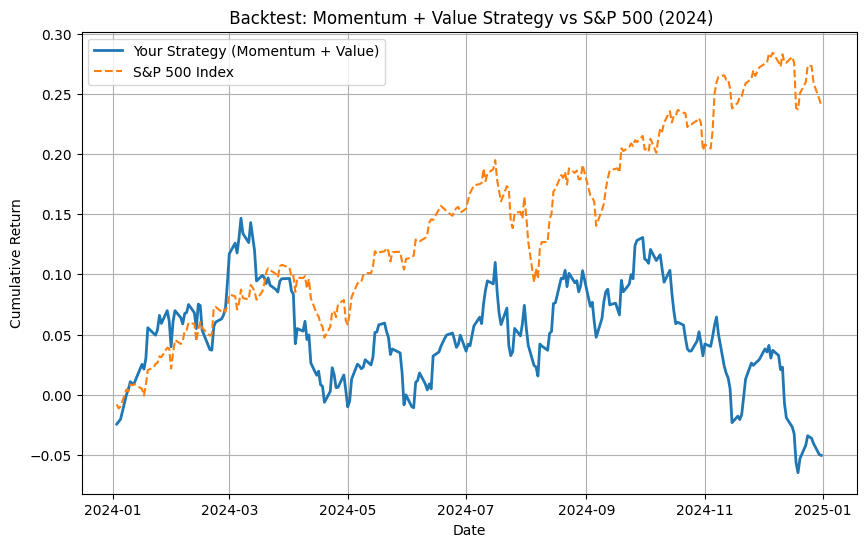

Final Portfolio Return: -5.04 %
 S&P 500 Return: Ticker
^GSPC    24.01
Name: 2024-12-31 00:00:00, dtype: float64 %


In [25]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

# Assume we already have: data, final_ranking, momentum_latest, value_df

# STEP 10: Pick Top N Stocks Based on Combined Score
top_n = 5
top_stocks = final_ranking['Ticker'].head(top_n).tolist()
print(f" Selected Top {top_n} Stocks:", top_stocks)

# STEP 11: Download their Price Data for the same period
backtest_data = yf.download(top_stocks, start="2024-01-01", end="2025-01-01", auto_adjust=False)['Adj Close']

# STEP 12: Calculate Portfolio Returns (Equal Weight)
returns = backtest_data.pct_change().dropna()
portfolio_returns = returns.mean(axis=1)
cumulative_portfolio = (1 + portfolio_returns).cumprod() - 1

# STEP 13: Compare Against S&P 500 Index (Benchmark)
benchmark = yf.download("^GSPC", start="2024-01-01", end="2025-01-01", auto_adjust=False)['Adj Close']
benchmark_returns = benchmark.pct_change().dropna()
benchmark_cumulative = (1 + benchmark_returns).cumprod() - 1

# STEP 14: Plot Results
plt.figure(figsize=(10,6))
plt.plot(cumulative_portfolio, label="Your Strategy (Momentum + Value)", linewidth=2)
plt.plot(benchmark_cumulative, label="S&P 500 Index", linestyle='--')
plt.title(" Backtest: Momentum + Value Strategy vs S&P 500 (2024)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.show()

# STEP 15: Final Performance Stats
print("Final Portfolio Return:", round(cumulative_portfolio.iloc[-1]*100, 2), "%")

print(" S&P 500 Return:", round(benchmark_cumulative.iloc[-1]*100, 2), "%")